<a href="https://colab.research.google.com/github/techpvk/techpvk/blob/master/resent50_custom_meetpvk_working_23_03_of_Vkt_TinyImageNet_StarterNotebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# List and Clear the Data first
!ls
!rm -rf sample_data tiny-imagenet-200	tiny-imagenet-200.zip

tiny-imagenet-200  tiny-imagenet-200.zip


In [0]:
# list content after the clearing data
!ls

In [3]:
# Download the file
!wget http://cs231n.stanford.edu/tiny-imagenet-200.zip

--2019-03-29 17:18:38--  http://cs231n.stanford.edu/tiny-imagenet-200.zip
Resolving cs231n.stanford.edu (cs231n.stanford.edu)... 171.64.68.10
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248100043 (237M) [application/zip]
Saving to: ‘tiny-imagenet-200.zip’

tiny-imagenet-200.z 100%[===================>] 236.61M  38.8MB/s    in 7.4s    

2019-03-29 17:18:46 (31.8 MB/s) - ‘tiny-imagenet-200.zip’ saved [248100043/248100043]



In [4]:
#unzip and list
!unzip -qq 'tiny-imagenet-200.zip'
!ls

tiny-imagenet-200  tiny-imagenet-200.zip


In [5]:
# import the required packages
import pandas as pd
import numpy as np
import six
from keras.preprocessing.image import ImageDataGenerator
from __future__ import division
from keras.models import Model
from keras.layers import (
    Input,
    Activation,
    Dense,
    Flatten,
    Dropout,
    SeparableConv2D
)
from keras.layers.convolutional import (
    Conv2D,
    MaxPooling2D,
    AveragePooling2D
)
from keras.layers.merge import add
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2
from keras import backend as K
from __future__ import print_function
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
from keras.callbacks import ReduceLROnPlateau, CSVLogger, EarlyStopping
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt
import os
import cv2
from keras.layers import GlobalAveragePooling2D
from keras.models import Model, load_model, model_from_yaml
from keras.utils.vis_utils import plot_model

Using TensorFlow backend.


In [0]:
# load data
val_data = pd.read_csv('./tiny-imagenet-200/val/val_annotations.txt', sep='\t', header=None, names=['File', 'Class', 'X', 'Y', 'H', 'W'])
val_data.drop(['X', 'Y', 'H', 'W'], axis=1, inplace=True)
#val_data.head(10)

In [0]:
# Use Augmentaion parameters as required.
train_datagen = ImageDataGenerator(
    rescale= 1./255,
    zoom_range = 0.3,
    width_shift_range=0.3,
    height_shift_range=0.3,
    rotation_range=20,
    horizontal_flip=True
    )

valid_datagen = ImageDataGenerator(rescale=1./255)

In [8]:
train_generator = train_datagen.flow_from_directory( r'./tiny-imagenet-200/train/', target_size=(32, 32), color_mode='rgb', 
                                                    batch_size=200, class_mode='categorical', shuffle=True, seed=42)

Found 100000 images belonging to 200 classes.


In [9]:
validation_generator = valid_datagen.flow_from_dataframe(val_data, directory='./tiny-imagenet-200/val/images/', x_col='File', y_col='Class', target_size=(32, 32),
                                                    color_mode='rgb', class_mode='categorical', batch_size=200, shuffle=True, seed=42)


Found 10000 images belonging to 200 classes.


In [10]:
x_batch, y_batch = next(train_generator)
x_batch.shape

(200, 32, 32, 3)

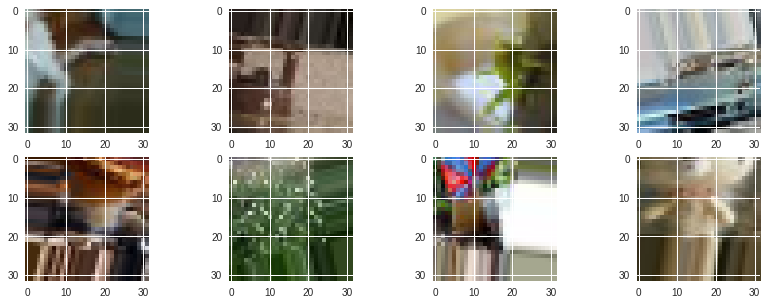

In [11]:
# Plot Generator images.  ** Re-run the cell to view different set of images.

fig = plt.figure(figsize=(14, 5))

for i in range(8):
    sub = fig.add_subplot(2, 4, i + 1)
    sub.imshow(x_batch[i,:,:], interpolation='nearest')

In [0]:
def _bn_relu(input):
    """Helper to build a BN -> relu block
    """
    norm = BatchNormalization(axis=CHANNEL_AXIS)(input)
    return Activation("relu")(norm)


def _conv_bn_relu(**conv_params):
    """Helper to build a conv -> BN -> relu block
    """
    filters = conv_params["filters"]
    name = conv_params["name"]
    kernel_size = conv_params["kernel_size"]
    strides = conv_params.setdefault("strides", (1, 1))
    kernel_initializer = conv_params.setdefault("kernel_initializer", "he_normal")
    padding = conv_params.setdefault("padding", "same")
    kernel_regularizer = conv_params.setdefault("kernel_regularizer", l2(1.e-4))
    def f(input):
        print("first _conv_bn_relu Conv2D() start")
        conv = SeparableConv2D(filters=filters, kernel_size=kernel_size,
                      strides=strides, padding=padding,
                      kernel_initializer=kernel_initializer,
                      kernel_regularizer=kernel_regularizer,
                     name=name)(input)
        print("first _conv_bn_relu Conv2D() end")
        return _bn_relu(conv)

    return f


def _bn_relu_conv(**conv_params):
    """Helper to build a BN -> relu -> conv block.
    This is an improved scheme proposed in http://arxiv.org/pdf/1603.05027v2.pdf
    """
    filters = conv_params["filters"]
    kernel_size = conv_params["kernel_size"]
    strides = conv_params.setdefault("strides", (1, 1))
    kernel_initializer = conv_params.setdefault("kernel_initializer", "he_normal")
    padding = conv_params.setdefault("padding", "same")
    kernel_regularizer = conv_params.setdefault("kernel_regularizer", l2(1.e-4))
    print("first _bn_relu_conv Conv2D() start")
    def f(input):
        activation = _bn_relu(input)
        print("first _bn_relu_conv Conv2D() end")
        return SeparableConv2D(filters=filters, kernel_size=kernel_size,
                      strides=strides, padding=padding,
                      kernel_initializer=kernel_initializer,
                      kernel_regularizer=kernel_regularizer)(activation)

    return f


def _shortcut(input, residual):
    """Adds a shortcut between input and residual block and merges them with "sum"
    """
    # Expand channels of shortcut to match residual.
    # Stride appropriately to match residual (width, height)
    # Should be int if network architecture is correctly configured.
    print("_shortcut start")
    input_shape = K.int_shape(input)
    residual_shape = K.int_shape(residual)
    stride_width = int(round(input_shape[ROW_AXIS] / residual_shape[ROW_AXIS]))
    stride_height = int(round(input_shape[COL_AXIS] / residual_shape[COL_AXIS]))
    equal_channels = input_shape[CHANNEL_AXIS] == residual_shape[CHANNEL_AXIS]

    shortcut = input
    # 1 X 1 conv if shape is different. Else identity.
    if stride_width > 1 or stride_height > 1 or not equal_channels:
        print("_shortcut  stride_width: ",stride_width,"stride_height: ",stride_height,"equal_channels: ",equal_channels)
        print("Conv2D start")
        shortcut = SeparableConv2D(filters=residual_shape[CHANNEL_AXIS],
                          kernel_size=(1, 1),
                          strides=(stride_width, stride_height),
                          padding="valid",
                          kernel_initializer="he_normal",
                          kernel_regularizer=l2(0.0001))(input)
        print("Conv2D end")
    print("doing -> shortcut+residual")
    return add([shortcut, residual])


def _residual_block(block_function, filters, repetitions, is_first_layer=False):
    """Builds a residual block with repeating bottleneck blocks.
    """
    def f(input):
        
        for i in range(repetitions):
            print("_residual_block start"," i:",i," repetitions:",repetitions)
            init_strides = (1, 1)
            if i == 0 and not is_first_layer:
                init_strides = (2, 2)
            input = block_function(filters=filters, init_strides=init_strides,
                                   is_first_block_of_first_layer=(is_first_layer and i == 0))(input)
            print("_residual_block end"," i:",i," repetitions:",repetitions)
        return input

    return f


def basic_block(filters, init_strides=(1, 1), is_first_block_of_first_layer=False):
    """Basic 3 X 3 convolution blocks for use on resnets with layers <= 34.
    Follows improved proposed scheme in http://arxiv.org/pdf/1603.05027v2.pdf
    """
    def f(input):

        if is_first_block_of_first_layer:
            # don't repeat bn->relu since we just did bn->relu->maxpool
            conv1 = Conv2D(filters=filters, kernel_size=(3, 3),
                           strides=init_strides,
                           padding="same",
                           kernel_initializer="he_normal",
                           kernel_regularizer=l2(1e-4))(input)
        else:
            conv1 = _bn_relu_conv(filters=filters, kernel_size=(3, 3),
                                  strides=init_strides)(input)

        residual = _bn_relu_conv(filters=filters, kernel_size=(3, 3))(conv1)
        return _shortcut(input, residual)

    return f


def bottleneck(filters, init_strides=(1, 1), is_first_block_of_first_layer=False):
    """Bottleneck architecture for > 34 layer resnet.
    Follows improved proposed scheme in http://arxiv.org/pdf/1603.05027v2.pdf
    Returns:
        A final conv layer of filters * 4
    """
    def f(input):
        print("bottleneck-def f(input)")
        if is_first_block_of_first_layer:
            print("bottleneck-is_first_block_of_first_layer"," init_strides:",init_strides)
            # don't repeat bn->relu since we just did bn->relu->maxpool
            conv_1_1 = Conv2D(filters=filters, kernel_size=(1, 1),
                              strides=init_strides,
                              padding="same",
                              kernel_initializer="he_normal",
                              kernel_regularizer=l2(1e-4))(input)
        else:
            print("bottleneck-else block"," init_strides:",init_strides)
            conv_1_1 = _bn_relu_conv(filters=filters, kernel_size=(1, 1),
                                     strides=init_strides)(input)

        print("bottleneck-after condition before start of conv_3_3 -> residual-._shortcut")
        conv_3_3 = _bn_relu_conv(filters=filters, kernel_size=(3, 3))(conv_1_1)
        residual = _bn_relu_conv(filters=filters * 4, kernel_size=(1, 1))(conv_3_3)
        print("bottleneck-after condition  end of conv_3_3 -> residual-._shortcut")
        return _shortcut(input, residual)

    return f

def bottleneck_pyramid(filters, init_strides=(1, 1), is_first_block_of_first_layer=False):
    """Bottleneck architecture for > 34 layer resnet.
    Follows improved proposed scheme in http://arxiv.org/pdf/1603.05027v2.pdf
    Returns:
        A final conv layer of filters * 4
    """
    def f(input):
        print("bottleneck-def f(input)")
        if is_first_block_of_first_layer:
            print("bottleneck-is_first_block_of_first_layer")
            # don't repeat bn->relu since we just did bn->relu->maxpool
            conv_1_1 = SeparableConv2D(filters=filters, kernel_size=(1, 1),
                              strides=init_strides,
                              padding="same",
                              kernel_initializer="he_normal",
                              kernel_regularizer=l2(1e-4))(input)
        else:
            print("bottleneck-else block-vkt")
            conv_1_1 = _bn_relu_conv(filters=filters, kernel_size=(1, 1),
                                     strides=(1,1))(input)

        print("bottleneck-after condition before start of conv_3_3 -> residual-._shortcut")
        conv_3_3_1 = _bn_relu_conv(filters=filters * 2, kernel_size=(3, 3))(conv_1_1)
        conv_3_3_2 = _bn_relu_conv(filters=filters * 4, kernel_size=(3, 3))(conv_3_3_1)
        conv_3_3_3 = _bn_relu_conv(filters=filters * 8, kernel_size=(3, 3))(conv_3_3_2)
        if is_first_block_of_first_layer:
           return _shortcut(input, conv_3_3_3)
        else:
            conv_3_3_3 = _bn_relu(conv_3_3_3)
            conv_max_pool = MaxPooling2D(pool_size=(2, 2))(conv_3_3_3)
            residual = _bn_relu(conv_max_pool)
            #residual = _bn_relu_conv(filters=filters * 8, kernel_size=(3, 3))(conv_3_3_2)
            print("bottleneck-after condition  end of conv_3_3 -> residual-._shortcut")
            return _shortcut(input, residual)
          
    return f


def _handle_dim_ordering():
    global ROW_AXIS
    global COL_AXIS
    global CHANNEL_AXIS
    if K.image_dim_ordering() == 'tf':
        ROW_AXIS = 1
        COL_AXIS = 2
        CHANNEL_AXIS = 3
    else:
        CHANNEL_AXIS = 1
        ROW_AXIS = 2
        COL_AXIS = 3


def _get_block(identifier):
    print("_get_block() start")
    if isinstance(identifier, six.string_types):
        res = globals().get(identifier)
        if not res:
            raise ValueError('Invalid {}'.format(identifier))
        return res
    print("_get_block() end")
    return identifier


class ResnetBuilder(object):
    @staticmethod
    def build(input_shape, num_outputs, block_fn, repetitions):
        print("venkat-ResnetBuilder-build()")
        """Builds a custom ResNet like architecture.
        Args:
            input_shape: The input shape in the form (nb_channels, nb_rows, nb_cols)
            num_outputs: The number of outputs at final softmax layer
            block_fn: The block function to use. This is either `basic_block` or `bottleneck`.
                The original paper used basic_block for layers < 50
            repetitions: Number of repetitions of various block units.
                At each block unit, the number of filters are doubled and the input size is halved
        Returns:
            The keras `Model`.
        """
        _handle_dim_ordering()
        if len(input_shape) != 3:
            raise Exception("Input shape should be a tuple (nb_channels, nb_rows, nb_cols)")

        # Permute dimension order if necessary
        if K.image_dim_ordering() == 'tf':
            input_shape = (input_shape[1], input_shape[2], input_shape[0])
        print("_get_block() start from main")
        # Load function from str if needed.
        block_fn = _get_block(block_fn)
        print("_get_block() end from main")
        input = Input(shape=input_shape)
        print("Input() end from main")
        print("first _conv_bn_relu start from main")
        conv1 = _conv_bn_relu(filters=64, kernel_size=(3, 3), strides=(1, 1),name='init-2d')(input)
        print("first _conv_bn_relu end from main")
        #pool1 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding="same")(conv1)
        #x = Dropout(0.5)(pool1)
        #block = conv1
        block = input
        filters = 32
        for i, r in enumerate(repetitions):
            print("*** inside for loop!!! start"," i:",i," r:",r," filters:",filters," repetitions:",repetitions)
            block = _residual_block(block_fn, filters=filters, repetitions=r, is_first_layer=(i == 0))(block)
            filters *= 2
            print("*** inside for loop!!! end")

        # Last activation
        block = _bn_relu(block)

        # Classifier block
        #block_shape = K.int_shape(block)
        #pool2 = AveragePooling2D(pool_size=(block_shape[ROW_AXIS], block_shape[COL_AXIS]),
        #                         strides=(1, 1))(block)
        #flatten1 = Flatten()(pool2)
        #x = Dropout(0.5)(flatten1)
        #dense = Dense(units=num_outputs, kernel_initializer="he_normal",
        #              activation="softmax")(x)
        x = Conv2D(200, (1,1), strides=(1,1), padding='same', name='final2d', use_bias=False)(block)
        x = _bn_relu(x)
        x = GlobalAveragePooling2D(data_format='channels_last')(x)
        # out = Flatten()(x)
        out = Activation('softmax') (x)
        model = Model(inputs=input, outputs=out)
        return model

    @staticmethod
    def build_resnet_18(input_shape, num_outputs):
        return ResnetBuilder.build(input_shape, num_outputs, basic_block, [2, 2, 2, 2])

    @staticmethod
    def build_resnet_34(input_shape, num_outputs):
        return ResnetBuilder.build(input_shape, num_outputs, basic_block, [3, 4, 6, 3])

    @staticmethod
    def build_resnet_50(input_shape, num_outputs):
        print("venkat-build_resnet_50")
        return ResnetBuilder.build(input_shape, num_outputs, bottleneck, [3, 4, 6, 3])
      
    @staticmethod
    def build_resnet_50_pyramid(input_shape, num_outputs):
        print("venkat-build_resnet_50")
        return ResnetBuilder.build(input_shape, num_outputs, bottleneck_pyramid, [1, 1, 1, 1])

    @staticmethod
    def build_resnet_101(input_shape, num_outputs):
        return ResnetBuilder.build(input_shape, num_outputs, bottleneck, [3, 4, 23, 3])

    @staticmethod
    def build_resnet_152(input_shape, num_outputs):
        return ResnetBuilder.build(input_shape, num_outputs, bottleneck, [3, 8, 36, 3])



In [13]:
nb_classes = 200
#nb_epoch = 100
# input image dimensions
img_rows, img_cols = 32, 32
img_channels = 3
model = ResnetBuilder.build_resnet_50_pyramid((img_channels, img_rows, img_cols), nb_classes)
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


venkat-build_resnet_50
venkat-ResnetBuilder-build()
_get_block() start from main
_get_block() start
_get_block() end
_get_block() end from main
Input() end from main
first _conv_bn_relu start from main
first _conv_bn_relu Conv2D() start
Instructions for updating:
Colocations handled automatically by placer.
first _conv_bn_relu Conv2D() end
first _conv_bn_relu end from main
*** inside for loop!!! start  i: 0  r: 1  filters: 32  repetitions: [1, 1, 1, 1]
_residual_block start  i: 0  repetitions: 1
bottleneck-def f(input)
bottleneck-is_first_block_of_first_layer
bottleneck-after condition before start of conv_3_3 -> residual-._shortcut
first _bn_relu_conv Conv2D() start
first _bn_relu_conv Conv2D() end
first _bn_relu_conv Conv2D() start
first _bn_relu_conv Conv2D() end
first _bn_relu_conv Conv2D() start
first _bn_relu_conv Conv2D() end
_shortcut start
_shortcut  stride_width:  1 stride_height:  1 equal_channels:  False
Conv2D start
Conv2D end
doing -> shortcut+residual
_residual_block end

['test', 'words.txt', 'wnids.txt', 'model_plot.png', 'val', 'train']


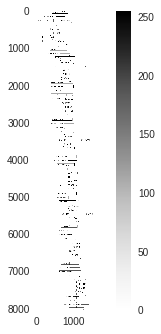

In [14]:
plot_model(model, to_file='./tiny-imagenet-200/model_plot.png', show_shapes=True, show_layer_names=True)
items = os.listdir('./tiny-imagenet-200')
print (items)    
image = cv2.imread('./tiny-imagenet-200/model_plot.png')
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
plt.figure()
plt.imshow(image)
plt.colorbar()
plt.grid(False)


In [0]:
from google.colab import files

files.download('./tiny-imagenet-200/model_plot.png')

In [16]:
model.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
separable_conv2d_1 (SeparableCo (None, 32, 32, 32)   131         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, 32, 32, 32)   128         separable_conv2d_1[0][0]         
__________________________________________________________________________________________________
activation_2 (Activation)       (None, 32, 32, 32)   0           batch_normalization_2[0][0]      
__________________________________________________________________________________________________
separable_

In [0]:
#model.fit_generator(train_generator, epochs=nb_epoch, steps_per_epoch=200, validation_steps=200, validation_data=validation_generator
##steps_per_epoch=Integer. Total number of steps (batches of samples) to yield from generator before declaring one epoch finished and starting the next epoch. 
#It should typically be equal to ceil(num_samples / batch_size) Optional for Sequence: if unspecified, will use the len(generator) as a number of steps.
##validation_steps=Only relevant if validation_data is a generator. Total number of steps (batches of samples) to yield from validation_data generator before stopping at the end of every epoch. 
#It should typically be equal to the number of samples of your validation dataset divided by the batch size. Optional for Sequence: if unspecified, will use the len(validation_data) as a number of steps.
##epochs: Integer. Number of epochs to train the model. An epoch is an iteration over the entire data provided, as defined by steps_per_epoch. 
#Note that in conjunction with initial_epoch, epochs is to be understood as "final epoch". The model is not trained for a number of iterations given by epochs,
#but merely until the epoch of index epochs is reached.
#steps_per_epoch=100000/200=500
#validation_steps=10000/200=50
#nb_epoch = 100
nb_epoch = 50
model.fit_generator(train_generator, epochs=nb_epoch, steps_per_epoch=500, validation_steps=50, validation_data=validation_generator)

Instructions for updating:
Use tf.cast instead.
Epoch 1/50
500/500 [==============================] - 639s 1s/step - loss: 4.6978 - acc: 0.0718 - val_loss: 7.0237 - val_acc: 0.0519
Epoch 2/50
500/500 [==============================] - 624s 1s/step - loss: 4.1198 - acc: 0.1481 - val_loss: 4.8604 - val_acc: 0.0795
Epoch 3/50
500/500 [==============================] - 625s 1s/step - loss: 3.7517 - acc: 0.2029 - val_loss: 4.0882 - val_acc: 0.1566
Epoch 4/50
500/500 [==============================] - 624s 1s/step - loss: 3.4600 - acc: 0.2503 - val_loss: 4.0318 - val_acc: 0.1660
Epoch 5/50
500/500 [==============================] - 625s 1s/step - loss: 3.2455 - acc: 0.2847 - val_loss: 3.8608 - val_acc: 0.2036
Epoch 6/50
500/500 [==============================] - 625s 1s/step - loss: 3.0818 - acc: 0.3130 - val_loss: 3.2839 - val_acc: 0.2802
Epoch 7/50
500/500 [==============================] - 625s 1s/step - loss: 2.9299 - acc: 0.3387 - val_loss: 3.3194 - val_acc: 0.2771
Epoch 8/50
500/500 [=

In [0]:
# Test the model
#score = model.evaluate(x_test, y_test, verbose=1)
#print('Test loss:', score[0])
model_yaml = model.to_yaml()
with open("session4_vkt_model240319.yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)
#print('Test accuracy:', score[1])
# Save the trained weights in to .h5 format
model.save_weights("session4_vkt_model240319.h5")
print("Saved the model to disk")
!ls


In [0]:
# load YAML and create model
!ls
yaml_file = open('session4_vkt_model240319.yaml', 'r')
loaded_model_yaml = yaml_file.read()
yaml_file.close()
##load from file
newmodel = model_from_yaml(loaded_model_yaml)
# load weights into new model
newmodel.load_weights("session4_vkt_model240319.h5")
print("Loaded model from disk")

# evaluate loaded model on test data
newmodel.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

newmodel.summary()


In [0]:
nb_epoch = 10
newmodel.fit_generator(train_generator, epochs=nb_epoch, steps_per_epoch=500, validation_steps=50, validation_data=validation_generator)